Vamos a aprender a utilizar Pytorch con operaciones que nos demuestren las ventajas de su uso.

1.1. Crea un array de NumPy y un tensor de Pytorch en base a la siguiente lista de Python:

In [3]:
import random
import numpy as np
import torch

seed = 64
random.seed(seed)
lista = [[float(random.randint(0, 9)) for i in range(0, 5000)] for i in range(0, 5000)]
np_array = np.array(lista)
t_tensor = torch.tensor(lista)

1.2. Completa la función "inverse_numpy". Esta función deberá recibir como parámetro un array de numpy de dos dimensiones, y devolver la matriz inversa correspondiente, utilizando numpy. Utilízala para invertir `np_array`.

In [ ]:
def inverse_numpy(array: np.array) -> np.array:
  return np.linalg.inv(array)



1.3. Completa la función "inverse_torch". Esta función deberá recibir como parámetro un tensor de torch de dos dimensiones y el dispositivo en el que ejecutar la operación, y devolver la matriz inversa correspondiente, utilizando torch. Utilízala para invertir `t_tensor`.

In [ ]:
def inverse_torch(tensor: torch.tensor, device: str) -> torch.tensor:
  tensor = tensor.to(device)
  return torch.inverse(tensor)




1.4. Utiliza la siguiente función para comparar cuánto tardan las funciones que has creado. Compara inverse_numpy contra inverse_torch en cpu contra inverse_torch en CUDA.

In [ ]:
from timeit import default_timer as timer

def time_inverses(inv_function):
    start_time = timer()
    inv_function()
    end_time = timer()
    time_taken = end_time - start_time
    print(f"tiempo: {time_taken}")

inverse_numpy_l = lambda: inverse_numpy(t_tensor)
inverse_torch_cpu = lambda: inverse_torch(t_tensor, "cpu")
inverse_torch_gpu = lambda: inverse_torch(t_tensor, "cuda")

time_inverses(inverse_numpy_l)
time_inverses(inverse_torch_cpu)
time_inverses(inverse_torch_gpu)

tiempo: 9.977180589
tiempo: 4.102874813999989
tiempo: 0.353033111000002


# Entrenar un modelo multicapa

Vamos a utilizar un modelo multicapa para predecir sobre el dataset iris de sklearn. Primero, ejecuta la siguiente celda para conseguir la X y la y.

In [4]:
# ----------- Ejecuta esta celda ----------- #

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

torch.manual_seed(1)

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)


In [5]:
X_train_norm.dtype

dtype('float64')

In [6]:
y_train

array([0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2,
       2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 1,
       2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0,
       2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       2, 0, 0, 2, 1, 2, 1, 2, 2, 1, 2, 0])

2.1. Convierte la X_train_norm y la y_train en un [TensorDataset](https://pytorch.org/docs/stable/data.html?highlight=tensordataset#torch.utils.data.TensorDataset) de torch. Recuerda que primero debes convertir la X y la y en tensores. Después, introduce ese dataset en un [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) de torch, con batch_size de 2 y shuffle igual a True.

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train_dataset = TensorDataset(torch.tensor(X_train_norm).float(), torch.tensor(y_train).float())
train_dl = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [8]:
train_dl

2.2. Construye el modelo. Este debe tener dos capas [lineales y completamente conectadas](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).
- Primero, construye cada capa dentro del método `__init__()` como atributos de la clase (recuerda que para ello, debes escribir `self` delante del nombre de la variable, como el `this` en Java).
- Después, en el método `forward`, aplica primero la operación de la capa y después la función de activación, para cada una de las dos capas. La función de activación de la capa uno deberá ser una [sigmoide](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), y la de la capa 2, una [Softmax con dim=1](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html).

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # La definición de las capas va aquí
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.layer2 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        # El proceso a través de las capas va aquí
        x = F.sigmoid(self.layer1(x))
        return F.softmax(self.layer2(x), 1)

2.3. Define el tamaño de las capas. El tamaño de `input_size` viene dado por X. El de la capa oculta debe ser 16, y el de la capa de salida debe ser 3, ya que nuestra clase tiene tres valores posibles. Usa estos valores para construir un modelo con la clase `Model`.

In [10]:
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

2.4. Define el learning_rate, la función de pérdida, y el optimizador.
- El learning_rate deberá ser 0.001.
- La función de pérdida deberá ser la de [entropía cruzada](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [11]:
learning_rate =0.001
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

2.5. Ejecuta el siguiente código para entrenar el modelo con los parámetros que has definido. Míralo con detenimiento para comprender qué está pasando.

In [ ]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

2.6. Ejecuta esta celda para ver cómo progresa tu modelo a lo largo de cada época.

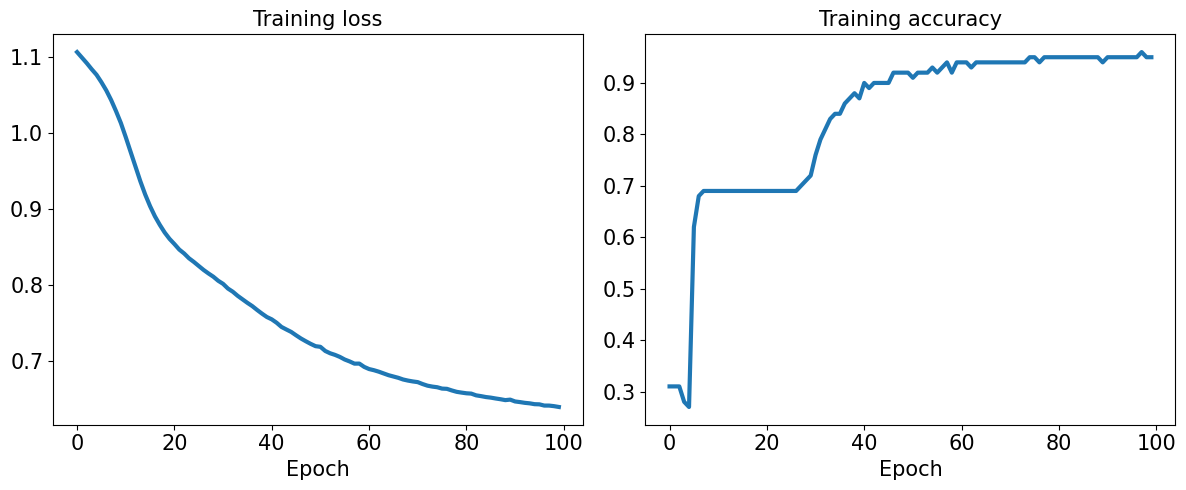

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')

plt.show()

2.7. Utiliza el método `predict` del modelo para predecir sobre `X_test`. Recuerda que primero debes normalizar la X. Puedes ver cómo hacerlo en el apartado 2.1. Una vez lo tengas, utiliza el método [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) para obtener una matriz de confusión y evaluar tu modelo.

<Figure size 300x300 with 0 Axes>

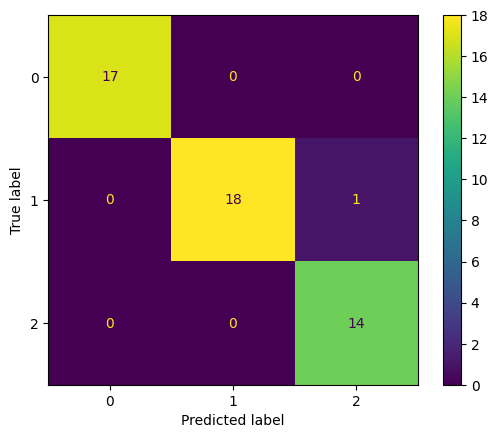

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)
X_test_tensor = torch.tensor(X_test_norm).float()
y_test_tensor = torch.tensor(y_test).float()

pred = model(torch.tensor(X_test_norm).float())
pred = torch.argmax(pred, dim=1)

cm = confusion_matrix(y_test_tensor.detach().numpy(), pred.detach().numpy())
plt.figure(figsize=[3,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
